<a href="https://colab.research.google.com/github/fcernafukuzaki/xgboost/blob/main/Cencosud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Caso: CAJA INKA

El objetivo del siguiente caso es identificar qué personas son más propensas a comprar un seguro de tarjeta de crédito a través de un modelo estadístico de predicción.

Autor: Francisco Cerna Fukuzaki

Fecha: 28/08/2023

# Paso 0: Conectar a Google Drive

In [139]:
# Conexión con Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Paso 1: Instalar paquete SHAP.

In [140]:
!pip install shap

# Paso 2: Importar paquetes.

In [182]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.utils import resample
from xgboost import XGBClassifier
import xgboost as xgb

import shap
shap.initjs()

In [142]:
%matplotlib inline

# Paso 3: Cargar dataset

In [143]:
%%time
archivo = "/content/drive/MyDrive/Colab Notebooks/cencosud-examen/BASE_EXAMEN.xlsx"
dataset = pd.read_excel(archivo)

CPU times: user 53.3 s, sys: 348 ms, total: 53.7 s
Wall time: 1min 13s


# Paso 4: Análisis exploratorio de datos (EDA)

In [144]:
dataset.head(10)

,ID,COMPRASEG,VAR01,VAR02,VAR03,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR010,VAR011,VAR012,VAR013,VAR014
0,1,0,-0.236376,-0.419902,20180902.0,-0.334187,-0.823758,-0.152608,-0.425952,0.297496,-0.633427,-0.049057,-0.579918,-0.869708,1.713473,region_2
1,2,0,0.078824,-0.190658,20230214.0,NaN,-1.003805,-0.152608,-0.451266,-0.760871,-0.669274,-0.053773,-0.586835,-0.869708,0.745937,region_1
2,9,0,-0.611287,-0.584548,20220219.0,0.280807,-0.000688,0.132828,-0.524808,1.355862,0.025297,0.042908,0.082709,1.335833,0.820363,region_4
3,12,0,-0.581431,2.476765,20140613.0,0.895801,1.568290,1.412408,-0.521404,-0.760871,3.131337,0.040550,1.596575,1.335833,1.862324,region_2
4,14,0,-0.650931,-0.308825,20150513.0,3.355777,1.568290,0.040331,-0.218178,0.297496,-0.191639,0.061773,-0.361337,1.335833,2.457731,region_2
5,17,0,-0.471062,1.483375,20180810.0,0.127058,0.590894,1.995397,-0.499496,1.355862,4.482279,0.049983,1.808960,1.335833,0.671511,region_1
6,19,0,-0.620341,-0.643631,20190131.0,0.434555,0.745220,-0.096524,-0.521783,-0.760871,-0.530395,0.039371,-0.587162,-1.310817,0.969215,region_1
7,21,0,-0.532976,-0.683020,20230318.0,NaN,-1.003805,-0.152608,-0.537649,-1.819237,-0.669274,-0.053773,-0.586835,-0.869708,1.564621,region_10
8,22,0,-0.532976,-0.683020,20230215.0,NaN,-1.003805,-0.152608,-0.541032,-1.819237,-0.669274,-0.053773,-0.586835,-0.869708,2.160028,region_5
9,23,0,0.211462,-0.092185,20201217.0,-0.949181,-1.003805,-0.152608,1.922855,-0.760871,-0.702217,-0.054952,0.034179,-0.869708,1.266918,region_4


Cantidad de datos que posee el dataset.

In [145]:
dataset.shape

(155064, 16)

Retirar valores vacíos o nulos.

In [146]:
dataset = dataset.dropna()

Cantidad de datos que posee el dataset luego de eliminar los valores vacíos.

In [147]:
dataset.shape

(133363, 16)

Análisis descriptivo de los datos numéricos y categóricos.

In [148]:
dataset.describe(include="all")

,ID,COMPRASEG,VAR01,VAR02,VAR03,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR010,VAR011,VAR012,VAR013,VAR014
count,133363.000000,133363.000000,133363.000000,133363.000000,1.333630e+05,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363.000000,133363
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,region_4
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,24973
mean,154212.882291,0.010115,0.002222,0.035660,2.019014e+07,0.028063,0.099481,0.022647,0.002455,0.084653,0.069108,0.007392,0.032368,0.134353,0.001466,NaN
std,89693.495951,0.100065,1.024402,1.040427,3.423269e+04,1.006478,0.991124,1.289667,1.000006,0.970754,1.036394,1.007665,1.028178,0.983227,0.994503,NaN
min,1.000000,0.000000,-2.242345,-0.781296,2.010072e+07,-1.102930,-1.003805,-0.152608,-0.555371,-1.819237,-1.445959,-22.910624,-0.587162,-1.310817,-3.347483,NaN
25%,76043.000000,0.000000,-0.601253,-0.584548,2.017100e+07,-0.641684,-0.798037,-0.152581,-0.515323,-0.760871,-0.507108,-0.047878,-0.511702,-0.869708,-0.817005,NaN
50%,153707.000000,0.000000,-0.419671,-0.387603,2.020062e+07,-0.180439,-0.257897,-0.152105,-0.388810,0.297496,-0.237456,-0.014865,-0.247059,0.453616,-0.072747,NaN
75%,231901.000000,0.000000,0.161294,0.203232,2.022033e+07,0.434555,1.311081,-0.010546,0.056087,0.297496,0.270089,0.040550,0.189237,0.894725,0.671511,NaN


Los datos han sido Normalización o Estandarización porque su media es 0 o muy cercana a 0, y su desviación estándar es casi 1. A excepción de las variables numéricas ID, COMPRASEG y VAR03 (día habilitación de la TC); y la variable categórica VAR014 (región).

Boxplots para detectar valores atípicos (outliers)

<Figure size 1000x800 with 0 Axes>

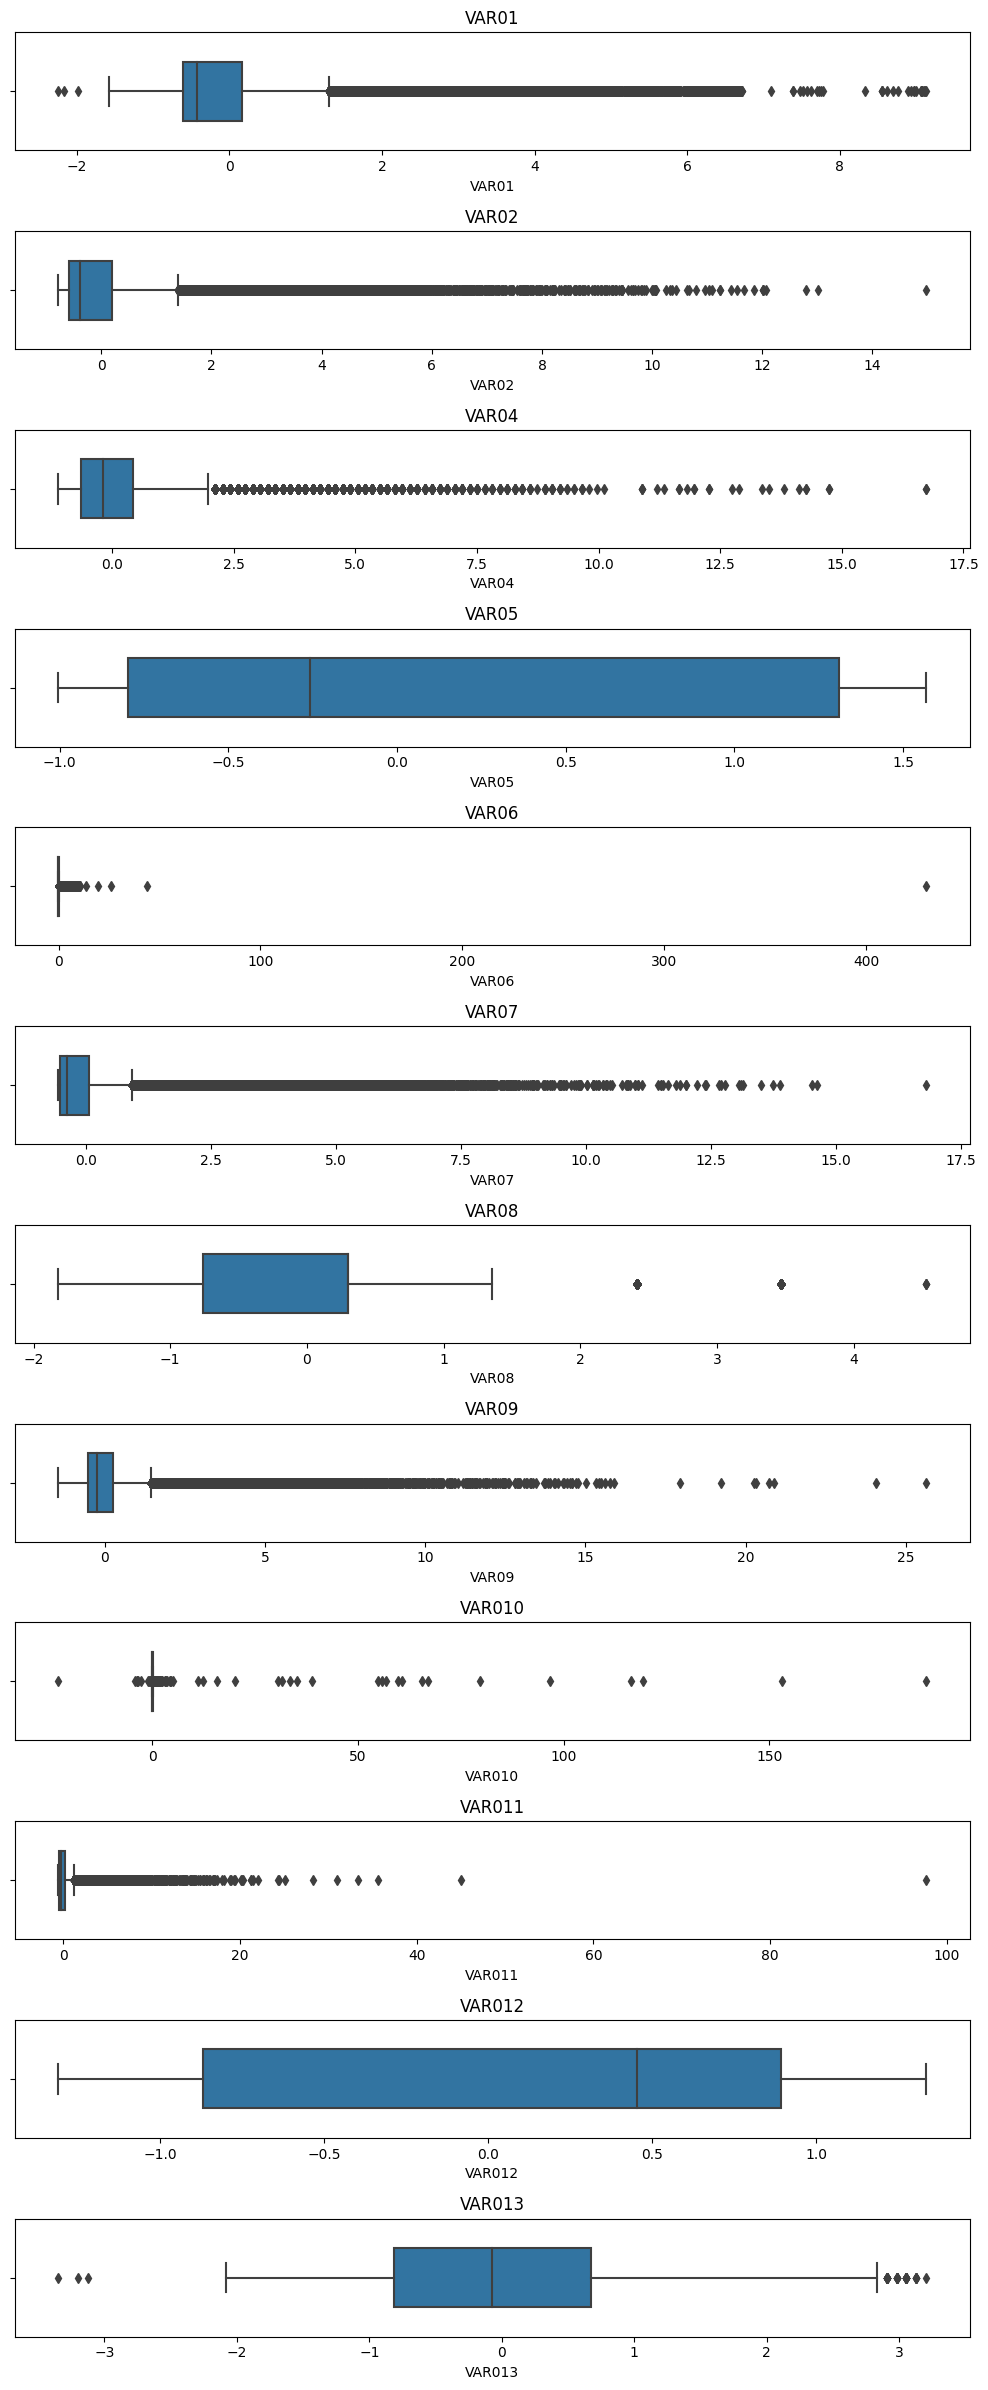

In [149]:
columnas_a_excluir = ['ID', 'COMPRASEG', 'VAR03', 'VAR014']

data_hist = dataset.loc[:, ~dataset.columns.isin(columnas_a_excluir)]

# Configura el tamaño de la figura
plt.figure(figsize=(10, 8))

# Define el número de filas y columnas para la disposición de los boxplots
num_filas = len(data_hist.columns)
num_columnas = 1

# Crea una matriz de subplots
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(10, 2 * num_filas))

# Itera a través de las columnas y crea un boxplot para cada una
for i, columna in enumerate(data_hist.columns):
    sns.boxplot(x=data_hist[columna], orient='h', width=0.5, ax=axes[i])
    axes[i].set_title(columna)
    axes[i].set_xlabel(columna)

plt.tight_layout()
plt.show()

Visualizar duplicados del campo identificador (ID).

In [150]:
# Supongamos que 'data' es tu DataFrame y 'ID' es la columna que deseas verificar
duplicados = dataset['ID'].duplicated()

# La serie 'duplicados' ahora contiene 'True' para cada fila que tiene un valor duplicado en 'ID'
# Para contar la cantidad de duplicados, puedes usar 'sum()' en la serie
cantidad_de_duplicados = duplicados.sum()

# Imprime la cantidad de duplicados y los primeros 10 registros con duplicados (para inspección)
print(f"Cantidad de Duplicados: {cantidad_de_duplicados}")

Cantidad de Duplicados: 0


Se identifica que el valor del identificador no se repite. Por lo que, no se puede asociar este campo a algún tipo de identificador de cliente.

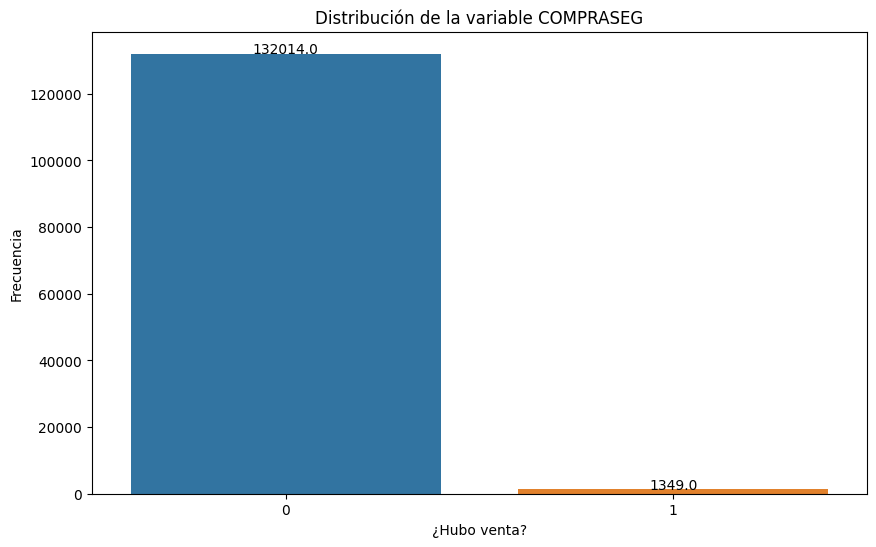

In [151]:
categoria_ordenada = dataset['COMPRASEG'].value_counts().index

# Crea el diagrama de barras ordenado
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='COMPRASEG', data=dataset, order=categoria_ordenada)
plt.xlabel('¿Hubo venta?')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable COMPRASEG')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

Se aprecia una gran diferencia entre los registros que no vendieron seguros y los que si vendieron seguros.

Submuestreo de la variable objetivo Indicador de compra de seguro al siguiente mes.

In [152]:
# Separar las clases mayoritaria (0) y minoritaria (1)
majority_class = dataset[dataset['COMPRASEG'] == 0]
minority_class = dataset[dataset['COMPRASEG'] == 1]

# Calcular cuántas muestras de la clase mayoritaria se necesitan en relación a la clase minoritaria
desired_majority_samples = len(minority_class) * 1

# Submuestreo de la clase mayoritaria para igualar el número de muestras de la clase minoritaria
majority_downsampled = resample(majority_class, replace=False, n_samples=desired_majority_samples, random_state=42)

# Combinar las muestras submuestreadas con la clase minoritaria
downsampled_data = pd.concat([majority_downsampled, minority_class])

Visualizar el resultado del submuestreo de los datos.

In [153]:
downsampled_data.shape

(2698, 16)

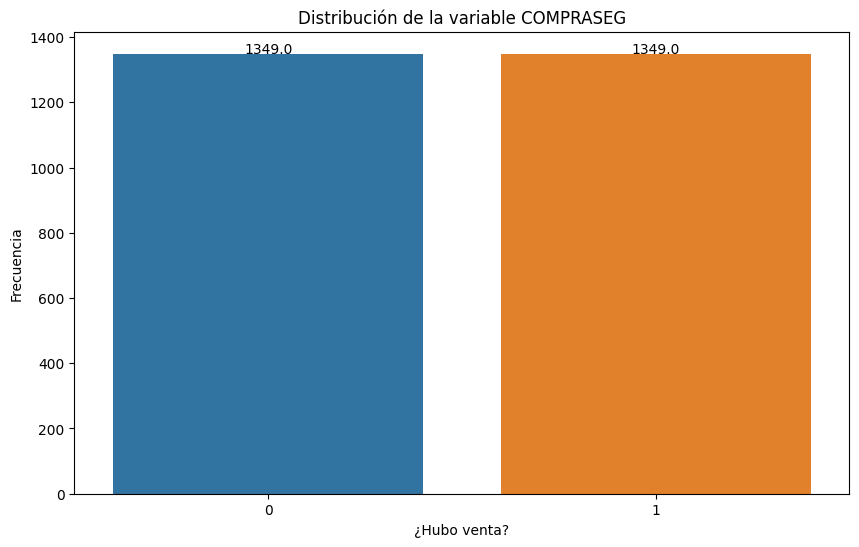

In [154]:
categoria_ordenada = downsampled_data['COMPRASEG'].value_counts().index

plt.figure(figsize=(10, 6))
ax = sns.countplot(x='COMPRASEG', data=downsampled_data, order=categoria_ordenada)
plt.xlabel('¿Hubo venta?')
plt.ylabel('Frecuencia')
plt.title('Distribución de la variable COMPRASEG')

for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

Reasignar el nombre del dataframe submuestreado o la variable `dataset`.

In [155]:
dataset = downsampled_data.copy()

Visualizar las variables numéricas.

<Figure size 1000x800 with 0 Axes>

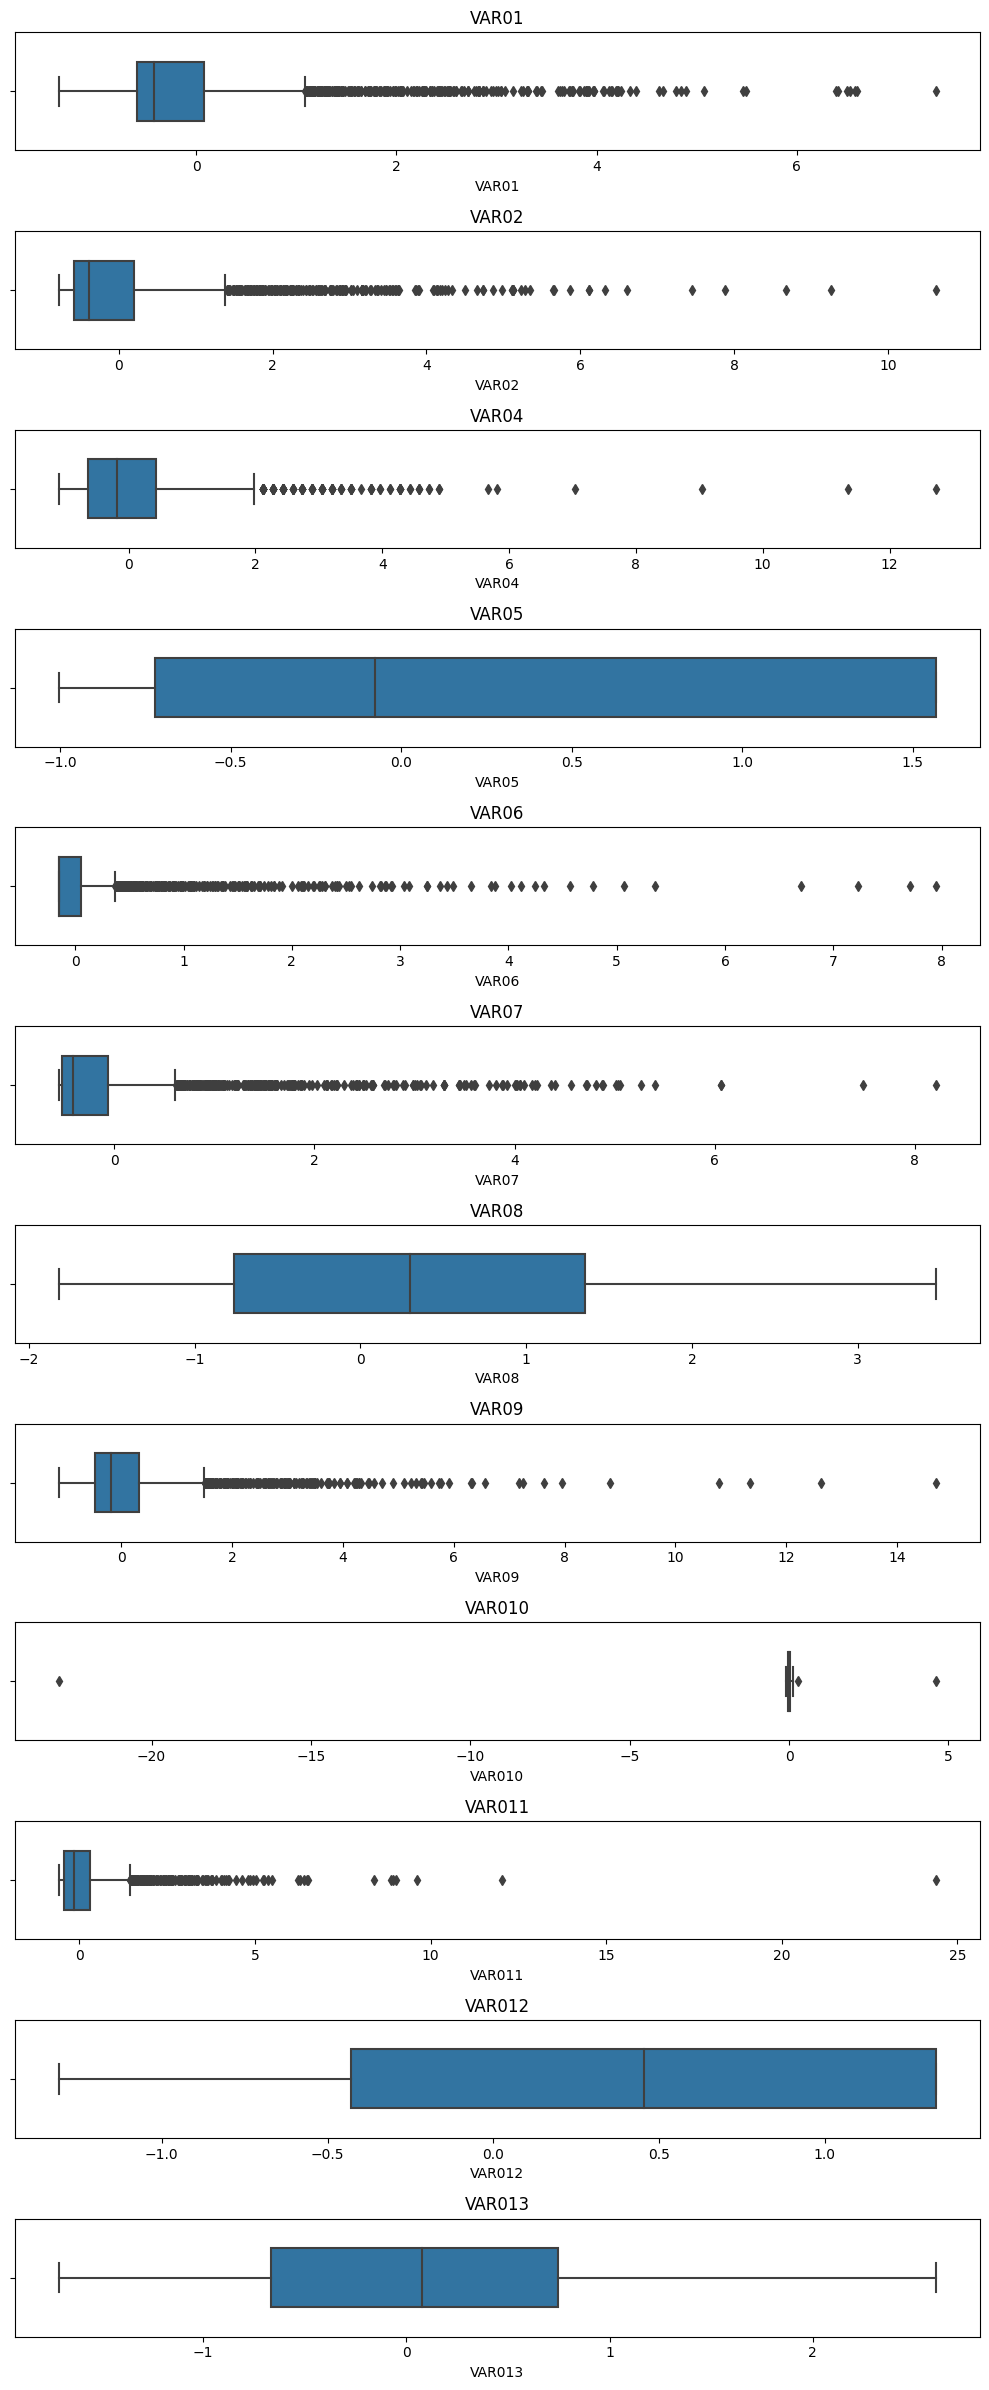

In [156]:
columnas_a_excluir = ['ID', 'COMPRASEG', 'VAR03', 'VAR014']

data_hist = dataset.loc[:, ~dataset.columns.isin(columnas_a_excluir)]

plt.figure(figsize=(10, 8))
num_filas = len(data_hist.columns)
num_columnas = 1
fig, axes = plt.subplots(num_filas, num_columnas, figsize=(10, 2 * num_filas))

for i, columna in enumerate(data_hist.columns):
    sns.boxplot(x=data_hist[columna], orient='h', width=0.5, ax=axes[i])
    axes[i].set_title(columna)
    axes[i].set_xlabel(columna)

plt.tight_layout()
plt.show()

Distribución de las regiones (variable categórica).

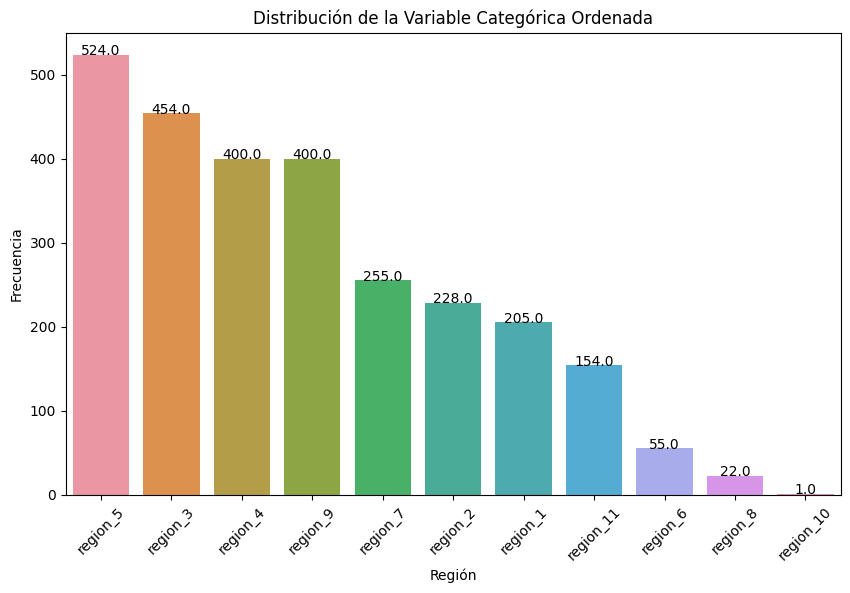

In [157]:
# Supongamos que tienes un DataFrame llamado 'data' y una columna categórica 'categoria'

# Ordena la columna 'categoria' en función de la frecuencia de cada categoría
categoria_ordenada = dataset['VAR014'].value_counts().index

# Crea el diagrama de barras ordenado
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='VAR014', data=dataset, order=categoria_ordenada)
plt.xticks(rotation=45)
plt.xlabel('Región')
plt.ylabel('Frecuencia')
plt.title('Distribución de la Variable Categórica Ordenada')

# Agrega etiquetas con la cantidad de cada categoría
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.show()

Distribución por año y mes.

In [158]:
dataset['VAR03_Ym'] = pd.to_datetime(dataset['VAR03'], format='%Y%m%d')

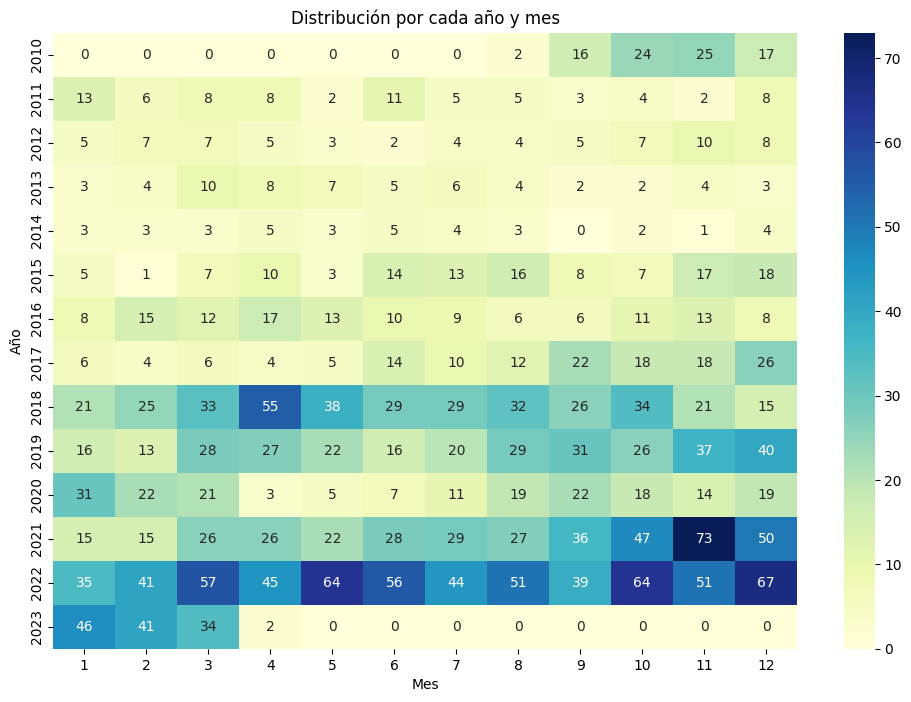

In [159]:
# Extrae el año y el mes de la fecha
dataset['año'] = dataset['VAR03_Ym'].dt.year
dataset['mes'] = dataset['VAR03_Ym'].dt.month

# Crea un DataFrame pivot para contar la cantidad de ocurrencias para cada combinación de año y mes
pivot_data = dataset.pivot_table(index='año', columns='mes', aggfunc='size', fill_value=0)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_data, annot=True, fmt='d', cmap='YlGnBu')
plt.xlabel('Mes')
plt.ylabel('Año')
plt.title('Distribución por cada año y mes')
plt.show()

Distribución de los clientes que compraron seguro al siguiente mes a lo largo de los años y meses.

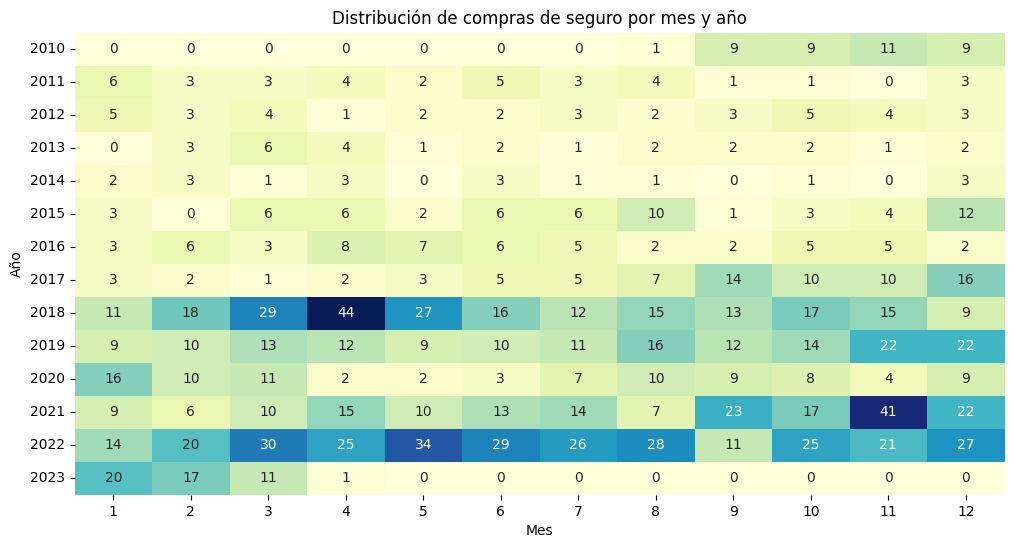

In [160]:
# Filtra las filas donde 'COMPRASEG' es igual a 1
compras_seguro = dataset[dataset['COMPRASEG'] == 1]

# Agrupa los datos por año y mes y cuenta la frecuencia de compras
compras_por_mes_y_año = compras_seguro.groupby(['año', 'mes']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 6))
sns.heatmap(compras_por_mes_y_año, annot=True, fmt='d', cmap='YlGnBu', cbar=False)
plt.xlabel('Mes')
plt.ylabel('Año')
plt.title('Distribución de compras de seguro por mes y año')
plt.show()

Se evidencia que el mes de marzo y abril del 2020 hubo una baja significativa en comparación de meses anteriores debido a la conyuntura nacional (pandemia de COVID-19). Sin embargo, a medida que pasaron los meses, la cantidad de clientes ha ido aumentando hasta obtener un número mucho mayor en comparación a antes de la pandemia.

Matriz de correlación.

Debido a efectos prácticos, utilizo un mapa de calor (heatmap) para visualizar la correlación entre las variables.

In [204]:
# Lista de nombres de las columnas que deseas excluir
columnas_a_excluir = ['ID', 'VAR03', 'VAR014', 'año', 'mes']

data_temp = dataset.loc[:, ~dataset.columns.isin(columnas_a_excluir)]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


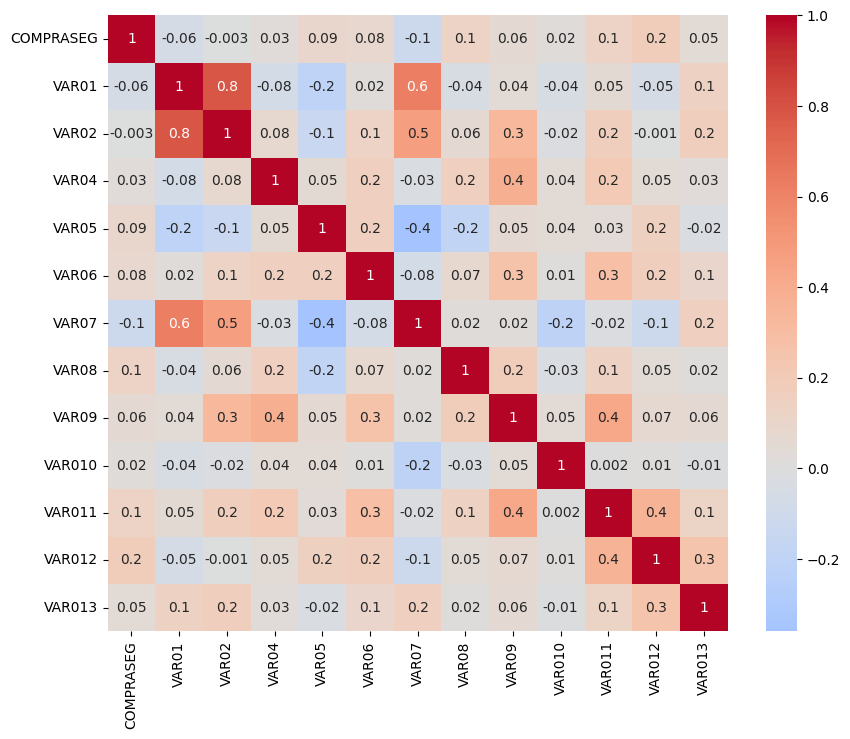

In [205]:
corr_matrix = pd.DataFrame(data_temp, columns=data_temp.columns).corr()

plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g'
            )
plt.show()

# Paso 5: Feature engineering

Crea columnas one-hot

In [163]:
# Lista de nombres de las columnas que deseas excluir
columnas_a_excluir = ['ID', 'VAR03']

data_temp = dataset.loc[:, ~dataset.columns.isin(columnas_a_excluir)]

data_temp = pd.get_dummies(data_temp, columns=['VAR014'], prefix='VAR014')

In [164]:
data_temp.head()

,COMPRASEG,VAR01,VAR02,VAR04,VAR05,VAR06,VAR07,VAR08,VAR09,VAR010,...,VAR014_region_10,VAR014_region_11,VAR014_region_2,VAR014_region_3,VAR014_region_4,VAR014_region_5,VAR014_region_6,VAR014_region_7,VAR014_region_8,VAR014_region_9
49543,0,-0.390060,-0.486075,4.739514,1.233918,-0.151897,-0.537928,0.297496,0.247261,-0.020760,...,0,0,0,0,0,0,0,1,0,0
18304,0,-0.666104,-0.663326,-0.334187,-0.900921,-0.152585,-0.553677,0.297496,-0.181990,0.072384,...,0,0,1,0,0,0,0,0,0,0
67592,0,-0.115973,-0.199520,-0.180439,-0.489386,-0.152525,-0.480114,-0.760871,-0.024347,-0.024297,...,0,0,0,0,1,0,0,0,0,0
149177,0,-0.392262,-0.505770,1.049549,-0.643712,-0.152558,-0.269690,-0.760871,-0.428363,-0.026655,...,0,0,0,0,0,1,0,0,0,0
13587,0,-0.807797,0.203232,3.202029,1.568290,7.950405,-0.507577,1.355862,2.969033,0.078279,...,0,0,0,0,0,1,0,0,0,0


In [171]:
# Crear la característica 'Promedio_Uso_Linea' (VAR01 + VAR10)
data_temp['Promedio_Uso_Linea'] = data_temp['VAR01'] + data_temp['VAR010']

# Crear la característica 'Frecuencia_Uso_Tarjeta' basada en VAR04
# labels=['Bajo Uso', 'Uso Moderado', 'Uso Frecuente']
data_temp['Frecuencia_Uso_Tarjeta'] = pd.cut(data_temp['VAR04'], bins=[-2, 0, 5, float('inf')], labels=[-1, 0, 1], right=False)
data_temp['Frecuencia_Uso_Tarjeta'] = data_temp['Frecuencia_Uso_Tarjeta'].astype(int)

# Crear la característica 'Uso_Tarjeta_Retail' basada en VAR011 y VAR12
data_temp['Uso_Tarjeta_Retail'] = data_temp['VAR011'] * data_temp['VAR012']

# Crear la característica 'Relacion_Deuda_Total' (VAR05 / VAR06)
data_temp['Relacion_Deuda_Total'] = data_temp['VAR05'] / data_temp['VAR06']

# Crear categorías de edad basadas en VAR13
bins = [-4, -2, 2, 4]
# labels = ['Adulto joven', 'Adulto', 'Adulto Mayor']
labels = [-1, 0, 1]
data_temp['Edad_Categorizada'] = pd.cut(data_temp['VAR013'], bins=bins, labels=labels)
data_temp['Edad_Categorizada'] = data_temp['Edad_Categorizada'].astype(int)

# Crear la característica 'Promedio_Deuda_Entidad' (VAR09 / VAR08)
data_temp['Promedio_Deuda_Entidad'] = data_temp['VAR09'] / data_temp['VAR08']

# Calcular la interacción entre VAR01 y VAR04
data_temp['Interaccion_VAR01_VAR04'] = data_temp['VAR01'] * data_temp['VAR04']

# Crear la característica 'Promedio_Uso_Reciente_Linea' (VAR07 / VAR09)
data_temp['Promedio_Uso_Reciente_Linea'] = data_temp['VAR07'] / data_temp['VAR09']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


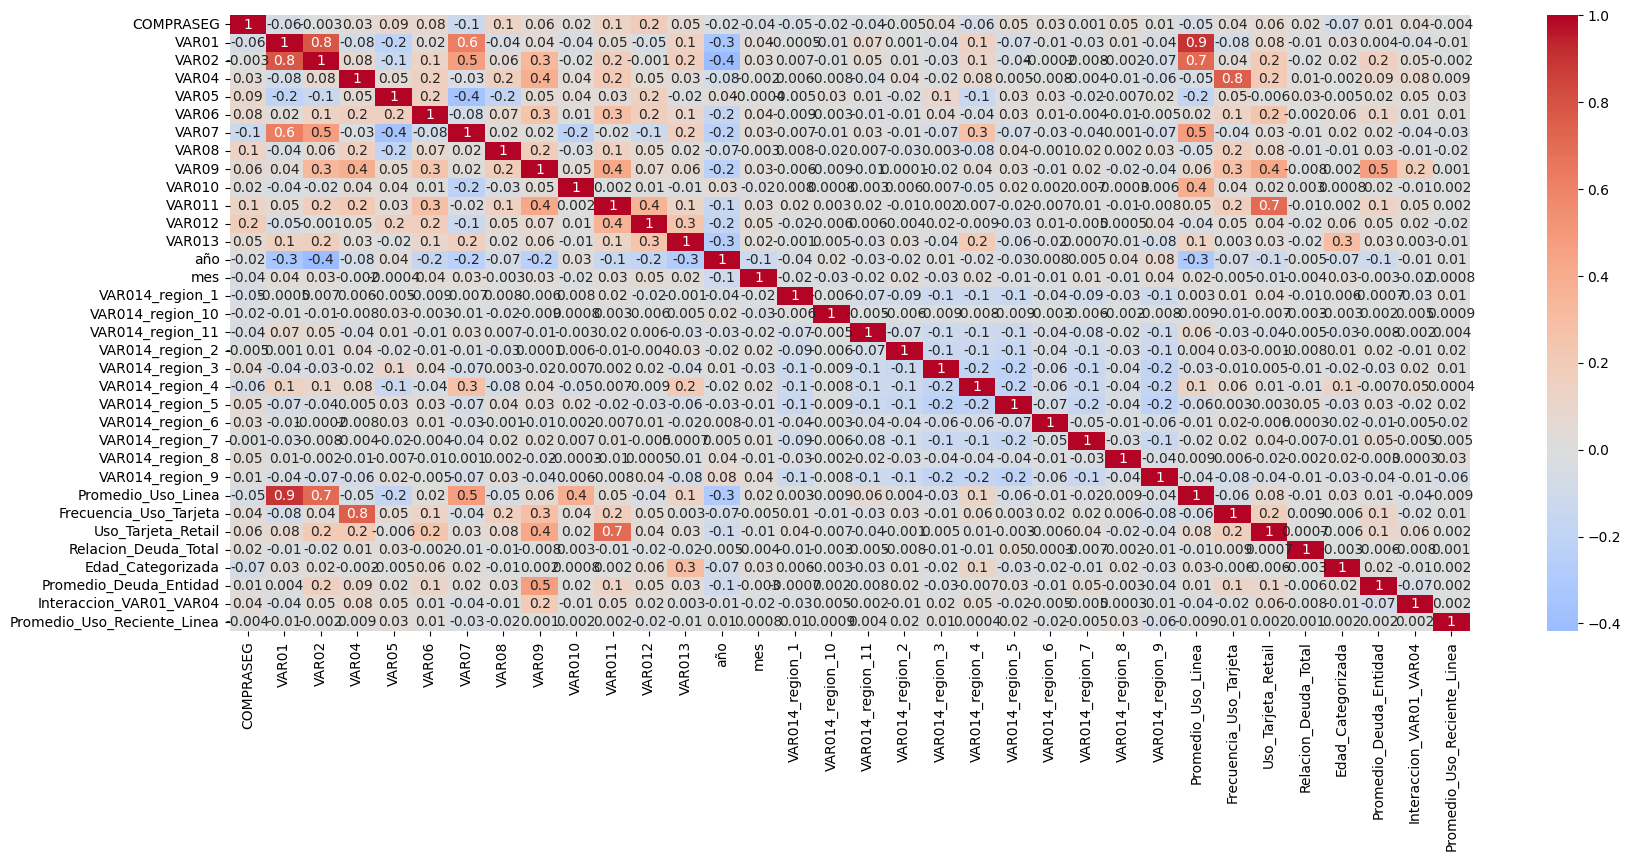

In [172]:
corr_matrix = pd.DataFrame(data_temp, columns=data_temp.columns).corr()

plt.figure(figsize=(20, 8))

sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.1g'
            )
plt.show()

Se crea una copia del dataset para ser utilizada en el modelo.

Retirar variables no necesarias.

In [173]:
data = data_temp.copy()

columnas_a_excluir = ['VAR03_Ym']
data = data.loc[:, ~data.columns.isin(columnas_a_excluir)]

# Paso 6: Modelado

Separar los dataset para entrenamiento y test. Distribuyo los valores en:

- Entrenamiento 70%
- Test 20%
- Validación 10%

In [183]:
# Divide el conjunto de datos en dos partes según el valor de 'COMPRASEG'
compras_seguro_NO = data[data['COMPRASEG'] == 0]
compras_seguro_SI = data[data['COMPRASEG'] == 1]

# Divide cada parte en conjuntos de entrenamiento y test (70% train y 30% test)
train_0, test_0 = train_test_split(compras_seguro_NO, test_size=0.3, random_state=0)
train_1, test_1 = train_test_split(compras_seguro_SI, test_size=0.3, random_state=0)

# Combina los conjuntos de entrenamiento y test de ambas partes
train = pd.concat([train_0, train_1])

# Divide cada parte en conjuntos de test y validación (20% test y 10% validation)
test_0, validation_0 = train_test_split(test_0, test_size=0.33, random_state=0)
test_1, validation_1 = train_test_split(test_1, test_size=0.33, random_state=0)

test = pd.concat([test_0, test_1])
validation = pd.concat([validation_0, validation_1])

La cantidad de datos para entrenamiento, test y validación son:

In [175]:
train.shape

(1888, 34)

In [176]:
test.shape

(542, 34)

In [177]:
validation.shape

(268, 34)

Separar las variables predictoras y la variable objetivo.

In [184]:
def get_X_Y(data, target='COMPRASEG'):
    X = data.drop(target,axis=1)
    y = data[target]
    return X, y

In [185]:
X, y = get_X_Y(data)
X_train, y_train = get_X_Y(train)
X_test, y_test = get_X_Y(test)
X_validation, y_validation = get_X_Y(validation)

Modelado

In [186]:
%%time

model = XGBClassifier(
    objective='binary:logistic'
)

model.fit(X_train, y_train,
          eval_set=[(X_test, y_test), (X_validation, y_validation)],
          eval_metric=['auc','error'],
          early_stopping_rounds=10,
          verbose=True)

[0]	validation_0-auc:0.61498	validation_0-error:0.41144	validation_1-auc:0.55764	validation_1-error:0.44030
[1]	validation_0-auc:0.63634	validation_0-error:0.39114	validation_1-auc:0.57435	validation_1-error:0.42164
[2]	validation_0-auc:0.64431	validation_0-error:0.39852	validation_1-auc:0.58345	validation_1-error:0.43657
[3]	validation_0-auc:0.65321	validation_0-error:0.38745	validation_1-auc:0.57755	validation_1-error:0.44403
[4]	validation_0-auc:0.64828	validation_0-error:0.40037	validation_1-auc:0.57301	validation_1-error:0.44030
[5]	validation_0-auc:0.64815	validation_0-error:0.40221	validation_1-auc:0.57323	validation_1-error:0.44776
[6]	validation_0-auc:0.64506	validation_0-error:0.40959	validation_1-auc:0.58059	validation_1-error:0.44030
[7]	validation_0-auc:0.65305	validation_0-error:0.40221	validation_1-auc:0.57947	validation_1-error:0.44403
[8]	validation_0-auc:0.64873	validation_0-error:0.40959	validation_1-auc:0.57964	validation_1-error:0.45149
[9]	validation_0-auc:0.65592

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


CPU times: user 308 ms, sys: 3.67 ms, total: 312 ms
Wall time: 206 ms


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [187]:
y_pred = model.predict(X_test)

# Evalúa el rendimiento del modelo
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Imprime la precisión y la matriz de confusión
print(f'Precisión del modelo: {accuracy:.2f}')
print('Matriz de Confusión:')
print(confusion)
print('Reporte de Clasificación:')
print(report)

Precisión del modelo: 0.61
Matriz de Confusión:
[[149 122]
 [ 90 181]]
Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.62      0.55      0.58       271
           1       0.60      0.67      0.63       271

    accuracy                           0.61       542
   macro avg       0.61      0.61      0.61       542
weighted avg       0.61      0.61      0.61       542



Método de feature importance

Método agnóstico. Me dice la importancia de la variable según:

1) Peso. Cantidad de veces que aparece que una variable aparece en un árbol.

2) Ganancia. Representa cuánto aportó en promedio cada variable en cada subset.

3) Covertura. Cantidad de registros afectados promedio de las divisiones que usan la variable.

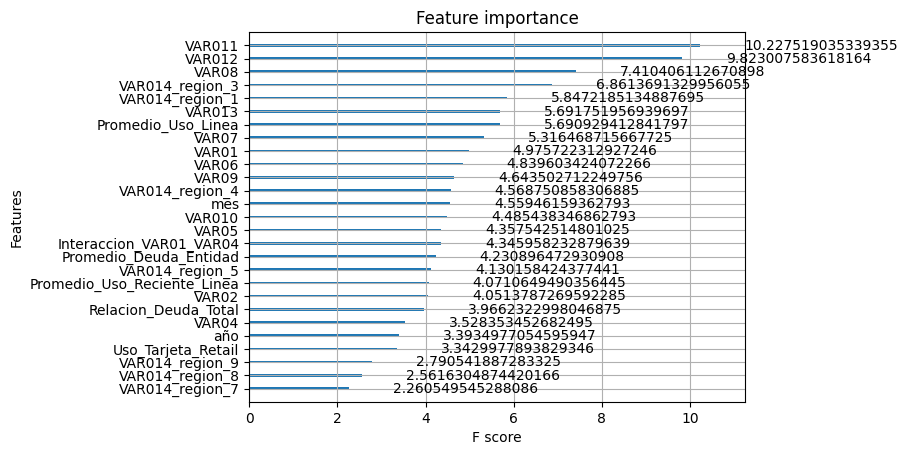

In [188]:
xgb.plot_importance(model, importance_type="gain")
plt.show()

Uso de la matriz de confusión para visualizar las predicciones correctas e incorrectas del modelo de clasificación.

#### Training accuracy

Score: 0.7251059322033898


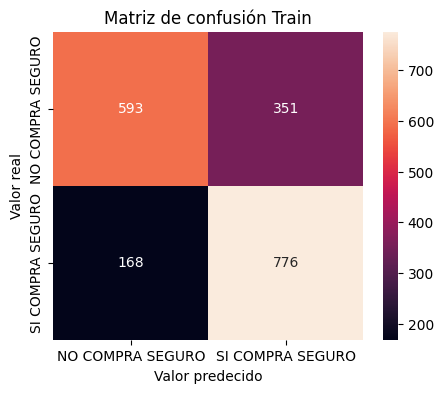

In [201]:
score = model.score(X_train, y_train)
print(f"Score: {score}")
predictions = model.predict(X_train)
conf_matrix = confusion_matrix(y_train, predictions)

cm_df = pd.DataFrame(conf_matrix,
                     index = ['NO COMPRA SEGURO','SI COMPRA SEGURO'],
                     columns = ['NO COMPRA SEGURO','SI COMPRA SEGURO'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Matriz de confusión Train')
plt.ylabel('Valor real')
plt.xlabel('Valor predecido')
plt.show()

#### Testing accuracy

Score: 0.6088560885608856


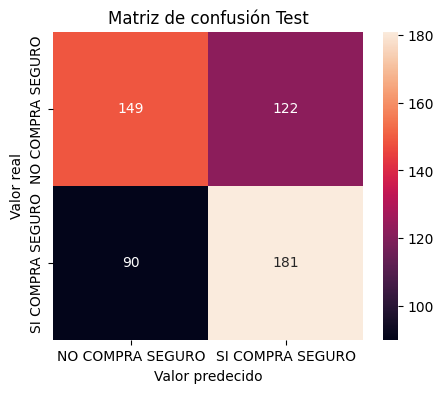

In [202]:
score = model.score(X_test, y_test)
print(f"Score: {score}")
predictions = model.predict(X_test)
conf_matrix = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(conf_matrix,
                     index = ['NO COMPRA SEGURO','SI COMPRA SEGURO'],
                     columns = ['NO COMPRA SEGURO','SI COMPRA SEGURO'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Matriz de confusión Test')
plt.ylabel('Valor real')
plt.xlabel('Valor predecido')
plt.show()

#### Validation accuracy

Score: 0.5783582089552238


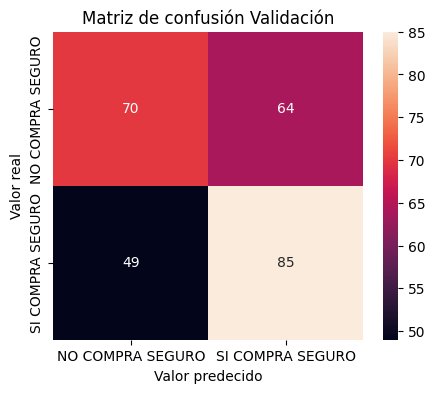

In [203]:
score = model.score(X_validation, y_validation)
print(f"Score: {score}")
predictions = model.predict(X_validation)
conf_matrix = confusion_matrix(y_validation, predictions)
cm_df = pd.DataFrame(conf_matrix,
                     index = ['NO COMPRA SEGURO','SI COMPRA SEGURO'],
                     columns = ['NO COMPRA SEGURO','SI COMPRA SEGURO'])

plt.figure(figsize=(5,4))
sns.heatmap(cm_df, annot=True, fmt='d')
plt.title('Matriz de confusión Validación')
plt.ylabel('Valor real')
plt.xlabel('Valor predecido')
plt.show()

# Paso 7: SHAP Values

Obtener gráficos shap que expliquen las variables que impactan más en el modelo.

In [196]:
%%time

explainer = shap.Explainer(model)
shap_values = explainer(X)

max_display = 50
plot_size = (12, 8)

CPU times: user 230 ms, sys: 922 µs, total: 230 ms
Wall time: 431 ms


Valor SHAP respecto a la salida del modelo.

Los valores son similares al Feature Importance.

Beeswarm plot

Si hay más largo en el color rojo es porque a medida que aumenta el valor de la variable, impacta más en el resultado.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


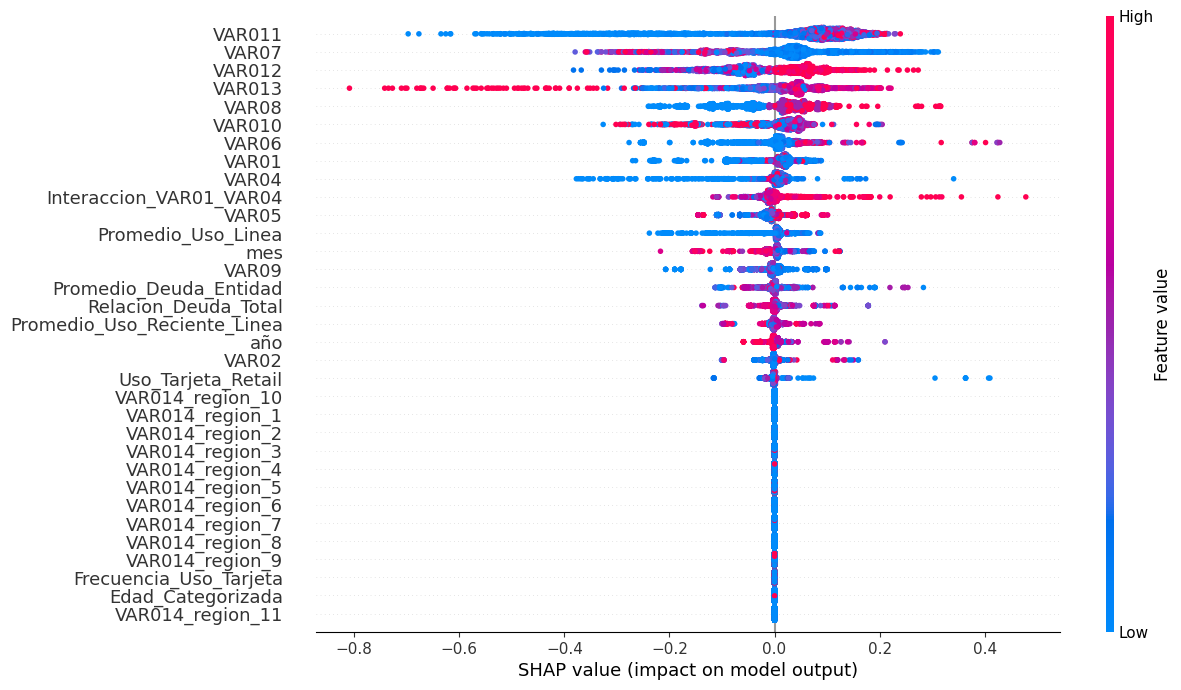

In [200]:
shap.plots.beeswarm(shap_values, max_display=max_display, plot_size=plot_size)

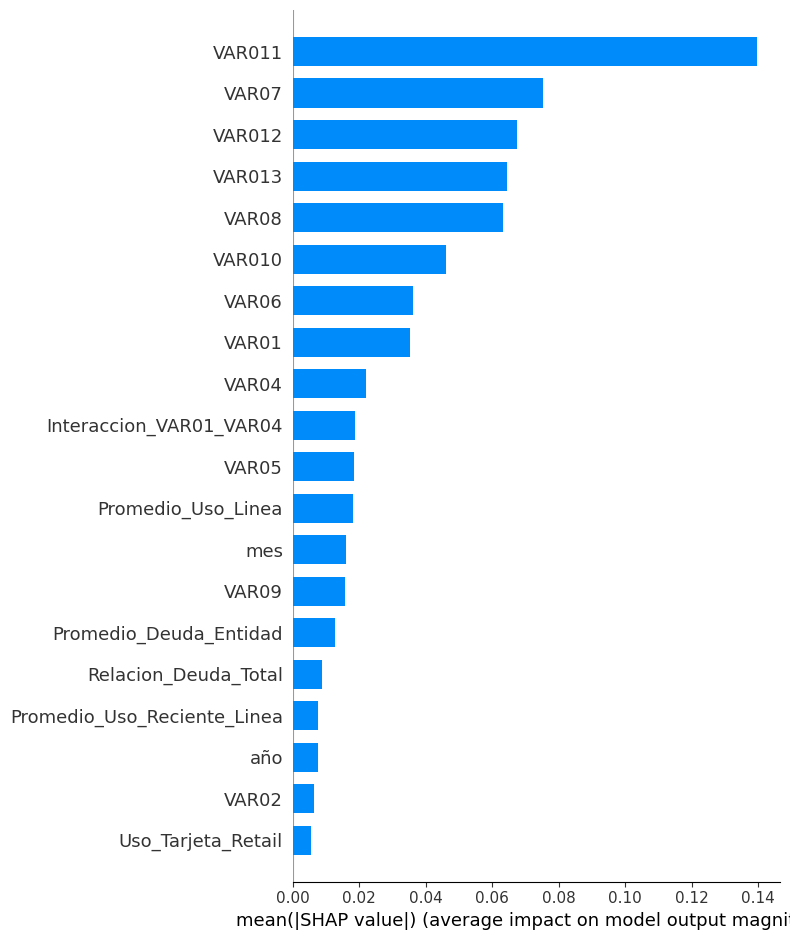

In [197]:
shap.summary_plot(shap_values, X, plot_type="bar")

Waterfall plot

Para predicción individual.

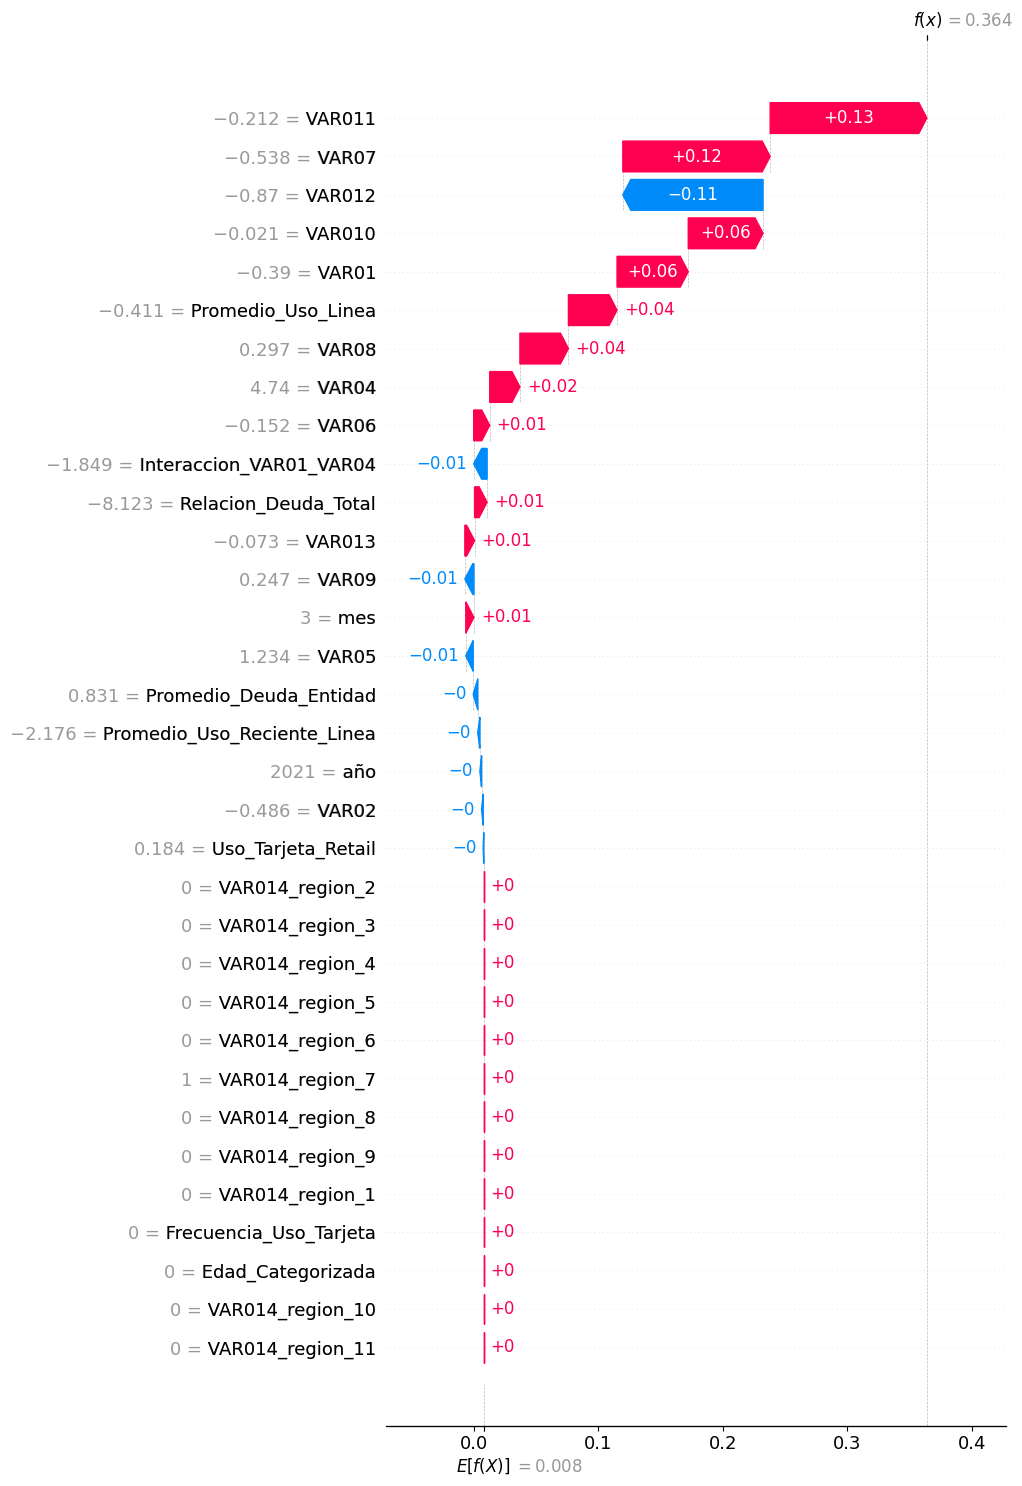

In [198]:
shap.plots.waterfall(shap_values[0], max_display=max_display)

E(F(x)) es el promedio de las predicciones de venta de seguros. Es el valor esperado.

f(X) es el número predecido de ventas de seguro para el caso en partícular.

Gráfico de fuerza (Force plot)

In [199]:
shap.initjs()
shap.plots.force(shap_values[0])

Gráfico de fuerza apilado (Stacked force plot)

In [ ]:
# shap.plots.force(shap_values)

Absolute Mean SHAP

In [ ]:
# shap.plots.bar(shap_values)

Dependence plots

In [ ]:
# shap.plots.scatter(shap_values[:,'VAR01'])